In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

In [341]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows', None)

# Import Data

In [342]:
items_df = pd.read_csv('csv_files/cleaned_items_df.csv',index_col=0).reset_index(drop=True)
reviews_df = pd.read_csv('csv_files/cleaned_reviews_df.csv',index_col=0).reset_index(drop=True).rename({'rating':'review_rating'},axis=1)

In [343]:
final_df = pd.merge(left=items_df, right=reviews_df, left_on='asin_id', right_on='asin_id')
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0


In [344]:
final_df.shape

(5490, 9)

In [345]:
reviews_df

,asin_id,review_id,review_title,review_description,user_rating
0,B076HK9H7Z,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0
1,B076HK9H7Z,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0
2,B076HK9H7Z,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0
3,B076HK9H7Z,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0
4,B076HK9H7Z,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0
...,...,...,...,...,...
5534,B07HM7WZT9,R3FHC0KYN67WQ5,A Modern Classic,One of the absolute best contemporary board ...,5.0
5535,B07HM7WZT9,R200X49K2TXHFS,Enjpy,Great product and update to the classic!,5.0
5536,B07HM7WZT9,R2J0LPLD5C3J7J,Fun... and different.,Great game,5.0
5537,B07HM7WZT9,R2TKR7XFXNWN18,Great game,Good update of the original Power Grid.,5.0


# Count of each User Rating

In [346]:
reviews_df['user_rating'].value_counts()

5.0    3542
4.0     707
1.0     567
3.0     444
2.0     279
Name: user_rating, dtype: int64

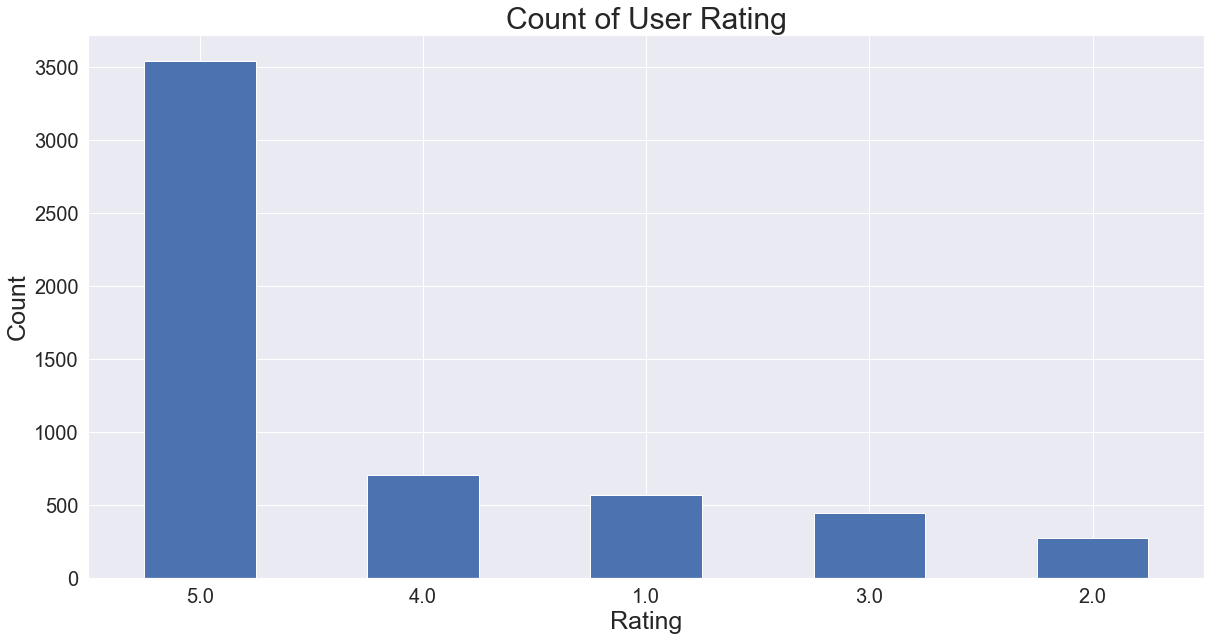

In [347]:
plt.figure(figsize=(20,10))
reviews_df['user_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=30)
plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)

plt.savefig('images/count_of_user_ratings.png');

It appears we have a class imbalance problem where the number of 5.0 reviews are much greater than the other reviews. This will cause difficulties to the machine learning algorithms so we will need to deal with it later.

# Lowest and Highest Price Item

In [348]:
items_df[items_df['price'] != 0]['price'].describe()

count    214.000000
mean      32.796168
std       46.321164
min        1.990000
25%       18.880000
50%       24.990000
75%       36.165000
max      648.980000
Name: price, dtype: float64

In [349]:
items_df[(items_df['price'] == 3.99) | (items_df['price'] == 169.99)]

,asin_id,name,price,avg_rating,no_of_ratings
139,B079XXJVQW,Game Night,3.99,4.5,2018


Based on all the board games collected, the highest priced board game is red wii mini console bundle @ 169.99 and lowest priced board game is gamemaster @ 3.99

# Number of Reviews by Board Game

In [350]:
items_df['no_of_ratings'].describe()

count      228.000000
mean      2172.618421
std       4216.751580
min          1.000000
25%        132.000000
50%        655.500000
75%       2416.250000
max      35987.000000
Name: no_of_ratings, dtype: float64

Item with the highest number of rating is 1 and highest number of rating is 35208. The mean is 2808 while the median is 1546 which tells us there are a lot more board games with a lot of ratings than of boards games with lower ratings.

# Top 10 Highest Reviewed Board Games

In [351]:
items_df.sort_values(by=['no_of_ratings'],ascending=False).head(10)

,asin_id,name,price,avg_rating,no_of_ratings
38,B010TQY7A8,Exploding Kittens Card Game - Family-Friendly ...,19.99,4.7,35987
41,B00ABA0ZOA,Jenga Classic Game,0.00,4.8,30394
46,B00D8STBHY,Hasbro Connect 4 Game,9.99,4.8,21600
153,B01MRG7T0D,What Do You Meme? Party Game,29.99,4.7,19090
32,B07P6MZPK3,Mattel Games UNO,9.99,4.9,13133
165,B014Q1XX9S,Czech Games Codenames,14.14,4.8,11934
7,B00000IVAK,SEQUENCE- Original SEQUENCE Game with Folding ...,15.17,4.8,11880
25,B00U26V4VQ,"Catan The Board Game, Multicolor",39.50,4.8,11069
13,B01MU9K3XU,Monopoly Classic Game,19.99,4.8,10481
93,0975277324,Ticket To Ride - Play With Alexa,48.11,4.8,9155


# 10 Least Reviewed Board Games

In [352]:
items_df.sort_values(by=['no_of_ratings'],ascending=True).head(10)

,asin_id,name,price,avg_rating,no_of_ratings
227,B083Q2FKTN,Escape Room The Game Expansion Pack – The Brea...,11.99,5.0,1
205,B082QSZ69K,Portal Games Detective: Season One,25.94,5.0,1
156,B08BHTL6SX,Wooden Large Sling Hockey Board Game 22inch Ca...,30.00,5.0,1
141,B08GYKSMX4,Tekhenu Obelisk of The Sun,53.30,5.0,1
160,B08B53WGWX,Alderac Entertainment Group (AEG) Calico,37.71,5.0,1
107,B084BJRQQB,Ravensburger The Castles of Tuscany Strategy G...,44.99,5.0,2
72,B085B23JHC,"Hedbanz Picture Guessing Board Game, for Famil...",11.99,4.6,3
140,B08H1HW596,Leder Games Fort Card Game,29.88,5.0,3
217,B08CZCLCQB,Aneco Halloween Ghost Dart Board Sticky Balls ...,14.99,4.0,3
184,B07ZP8HFNP,Joyful Mathematics MULTI Board Game,25.00,5.0,4


# Is there a correlation between price and number of ratings/avg_rating?

In [353]:
items_df[items_df['price'] != 0].corr(method ='pearson')

,price,avg_rating,no_of_ratings
price,1.000000,-0.061870,-0.091587
avg_rating,-0.061870,1.000000,0.122684
no_of_ratings,-0.091587,0.122684,1.000000


# Scatter Plot of Average Rating and Price

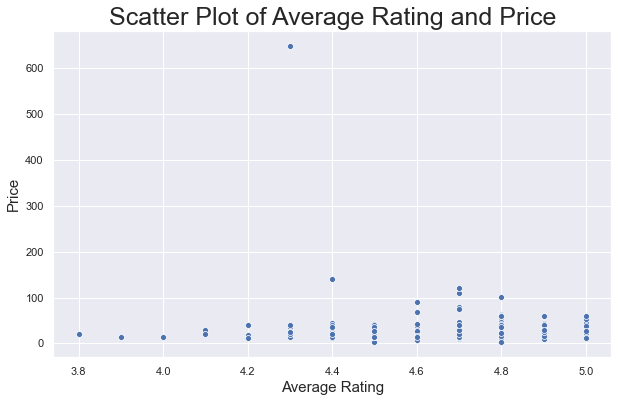

In [354]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=items_df[items_df['price'] != 0], x='avg_rating', y='price')
plt.title('Scatter Plot of Average Rating and Price',fontsize=25)
# Set x-axis label
plt.xlabel('Average Rating',fontsize=15)
# Set y-axis label
plt.ylabel('Price',fontsize=15)
sns.set(font_scale = 1)

plt.savefig('images/scatter_plot_avg_rating_and_price.png');

# Natural Language Processing (NLP)

Using natural language tool kit (NLTK) which is the most popular NLP libraries in Python, we're going to analyze the natural human language for all the amazon reviews in our data.

## Preprocessing using NLTK

In [355]:
# strip '/n' characters from title and description
final_df['review_title'] = final_df['review_title'].apply(lambda x:x.strip('\n'))

# was getting an error when stripping review_description due to N/A (row 56)
final_df['review_description'][final_df['review_description'].isna()]
final_df['review_description'] = final_df['review_description'].fillna('-1')
final_df['review_description'] = final_df['review_description'].apply(lambda x:x.strip('\n'))

In [356]:
def clean_text(text):
    
    cleaned_text = "".join([x for x in text if x not in string.punctuation]) # remove punctuation
    cleaned_text = cleaned_text.lower() # lowercase all characters
    cleaned_text = cleaned_text.strip() # strip whitespace
    cleaned_text = re.sub('[0-9]+', '', cleaned_text)
    
    # remove all emojis
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    cleaned_text = deEmojify(cleaned_text)
    
    tokens = cleaned_text.split(" ") # split string into list of words
    
    STOPWORDS=stopwords.words("english") # stopwords - commonly used words eg is, he, we, etc.
    cleaned_text = [token for token in tokens if token not in STOPWORDS] # filter out stopwords
    

    return ' '.join(cleaned_text)

## Tokenization

In [357]:
# tokenize the data
final_df['cleaned_title']= final_df['review_title'].apply(lambda x:clean_text(x))
final_df['cleaned_reviews']= final_df['review_description'].apply(lambda x:clean_text(x))

In [379]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero star could youre original sorr...
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawn per team instead trad...
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,buy replace old sorry game fall apart wish rea...
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warn sorry grow three token per player rule di...
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawn card instead dice...


## Lemmatization

In [358]:
final_df['cleaned_reviews']

0       would give zero stars could youre original sor...
1       original sorry game  pawns per team instead tr...
2       bought replace old sorry game falling apart  w...
3       warned sorry grew three tokens per player rule...
4       definitely classic game  pawns cards instead d...
                              ...                        
5485    one absolute best contemporary board games app...
5486                         great product update classic
5487                                           great game
5488                      good update original power grid
5489       better expected takes learn play good strategy
Name: cleaned_reviews, Length: 5490, dtype: object

In [359]:
# normalizes each word in review to its base form
# lemmatize takes part of speech parameter, if not supplied, default is noun
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

In [360]:
final_df['cleaned_reviews'] = final_df['cleaned_reviews'].apply(lambda x: ' '.join(lemmatize_sentence(x.split())))
final_df['cleaned_reviews']

0       would give zero star could youre original sorr...
1       original sorry game pawn per team instead trad...
2       buy replace old sorry game fall apart wish rea...
3       warn sorry grow three token per player rule di...
4       definitely classic game pawn card instead dice...
                              ...                        
5485    one absolute best contemporary board game appe...
5486                         great product update classic
5487                                           great game
5488                      good update original power grid
5489            good expect take learn play good strategy
Name: cleaned_reviews, Length: 5490, dtype: object

In [361]:
final_df.to_csv('csv_files/cleaned_items_reviews_df.csv')

## Unigram - Individual Words

### Common Words for Reviews

In [362]:
# convert dataframe series into frequency distribution
def convert_df_column_as_freq_dist(dataframe,column,no_common_words=10):

    word_dict = []

    for row in dataframe[column]:
        split_row = str(row).split()
        for word in split_row:
            word_dict.append(word)
            
    title_freqdist = FreqDist(word_dict)
    
    return title_freqdist.most_common(no_common_words)

In [363]:
most_common_words_reviews = dict(convert_df_column_as_freq_dist(final_df,'cleaned_reviews',no_common_words=20))
most_common_words_reviews

{'game': 14506,
 'play': 7070,
 'card': 3115,
 'get': 3081,
 'fun': 2871,
 'one': 2852,
 'board': 2562,
 'like': 2343,
 'make': 2128,
 'player': 2102,
 'love': 2091,
 'time': 2009,
 'great': 1747,
 'good': 1590,
 'kid': 1532,
 'really': 1525,
 'old': 1522,
 'would': 1492,
 'year': 1325,
 'family': 1314}

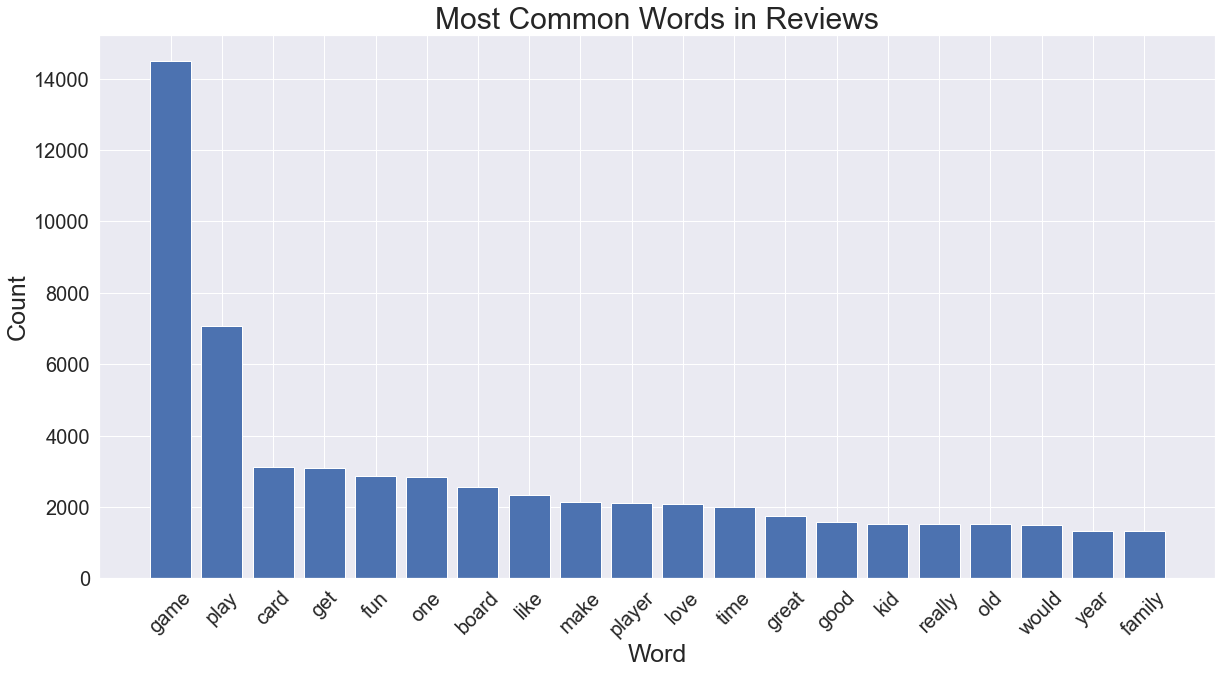

In [364]:
keys = most_common_words_reviews.keys()
values = most_common_words_reviews.values()

plt.figure(figsize=(20,10))
plt.title('Most Common Words in Reviews',fontsize=30)

plt.xlabel('Word',fontsize=25)
plt.xticks(fontsize=20, rotation=45)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)

plt.bar(keys, values)

plt.savefig('images/bar_plot_most_common_words_in_reviews.png');

### WordCloud for Most Common Words in Reviews

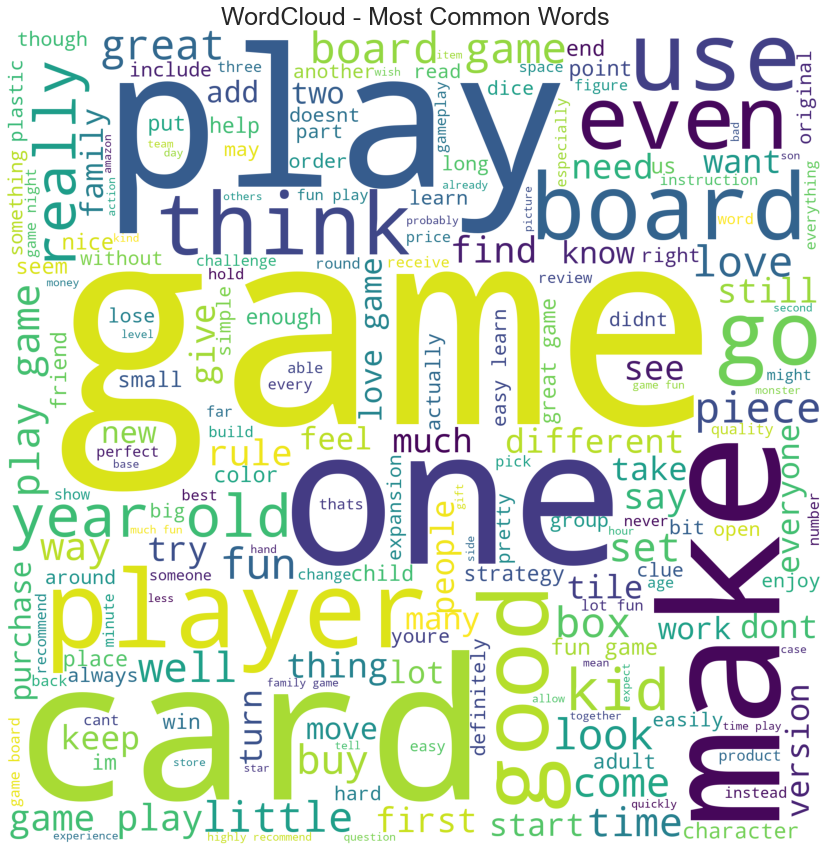

<Figure size 1440x1080 with 0 Axes>

In [365]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=2000, width=2000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(final_df['cleaned_reviews'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words", fontsize=25)
plt.axis('off')
plt.show()

plt.savefig('images/wordcloud_most_common_words_in_reviews.png');

# Bigrams

In [366]:
# convert dataframe column into a bag of words
def convert_df_column_as_freq_dist_bigrams(dataframe,column, reverse_order=True, no_of_bigrams=10):
    
    import itertools

    bigrams_dict = {}

    for row in dataframe[column]:
        nltk_token = nltk.word_tokenize(row)
        bigram = list(nltk.bigrams(nltk_token))
        for pair_bigram in bigram:
            if pair_bigram in bigrams_dict:
                bigrams_dict[pair_bigram] += 1
            else:
                bigrams_dict[pair_bigram] = 1 
    
    sorted_bigrams_dict = {k: v for k, v in sorted(bigrams_dict.items(), 
                                    key=lambda item: item[1],
                                    reverse=reverse_order)}
    
    return dict(itertools.islice(sorted_bigrams_dict.items(), no_of_bigrams))

In [367]:
# outputs the most common bigrams as a dictionary of frequency distribution
most_common_bigrams = convert_df_column_as_freq_dist_bigrams(final_df,'cleaned_reviews',
                                                             reverse_order=True,
                                                             no_of_bigrams=20)
most_common_bigrams

{('year', 'old'): 921,
 ('board', 'game'): 839,
 ('play', 'game'): 710,
 ('game', 'play'): 690,
 ('love', 'game'): 467,
 ('fun', 'game'): 419,
 ('great', 'game'): 360,
 ('easy', 'learn'): 301,
 ('fun', 'play'): 263,
 ('lot', 'fun'): 243,
 ('game', 'board'): 238,
 ('game', 'night'): 232,
 ('highly', 'recommend'): 230,
 ('game', 'fun'): 212,
 ('family', 'game'): 211,
 ('much', 'fun'): 209,
 ('feel', 'like'): 204,
 ('time', 'play'): 195,
 ('love', 'play'): 177,
 ('first', 'time'): 171}

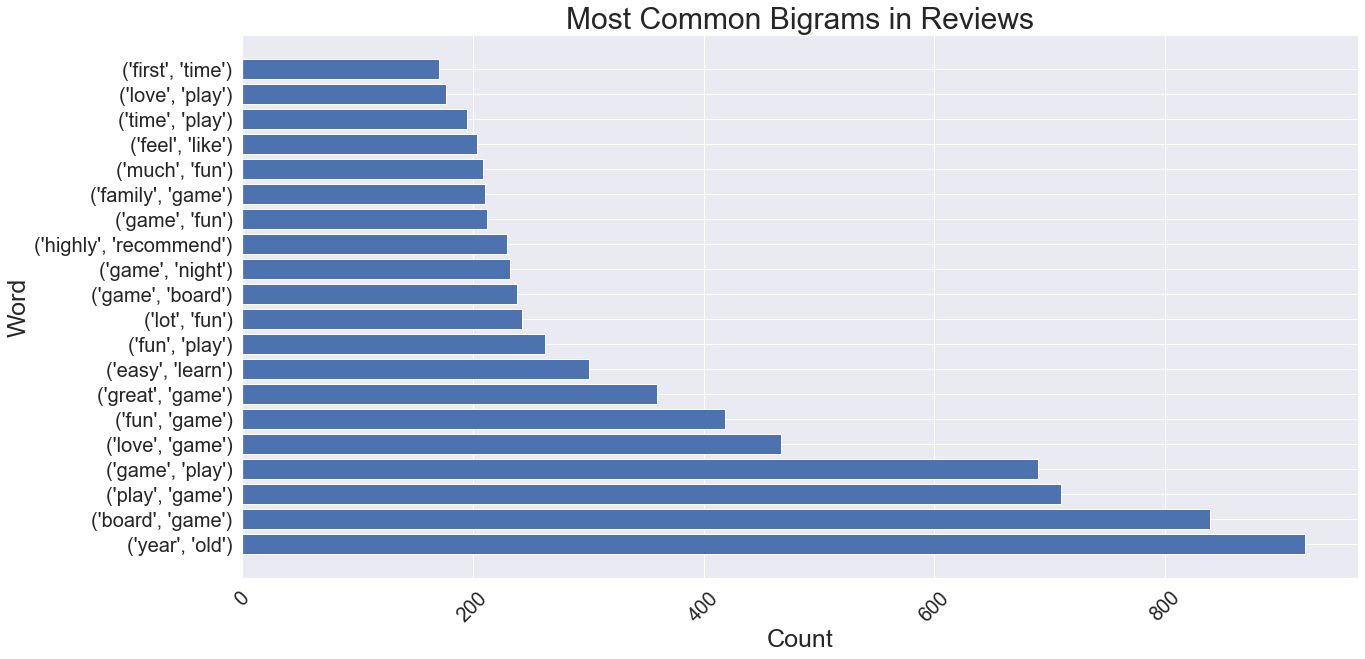

In [368]:
keys = [str(key) for key in most_common_bigrams.keys()]
values = most_common_bigrams.values()

plt.figure(figsize=(20,10))
plt.title('Most Common Bigrams in Reviews',fontsize=30)

plt.xlabel('Count',fontsize=25)
plt.xticks(fontsize=20, rotation=90)
plt.ylabel('Word',fontsize=25,)
plt.yticks(fontsize=20)
plt.tick_params(axis='x',labelsize=20,rotation=45)

plt.barh(keys, values)

plt.savefig('images/bar_plot_most_common_bigrams_in_reviews.png');

# Most Common Positive and Negative Words

In [369]:
# import lexicon positive english words
lexicon_positive_words = []
positive_file = open('opinion-lexicon-English/positive-words.txt', 'r')
for line in positive_file.readlines()[35:]:
    lexicon_positive_words.append(line.strip())

# import lexicon negative english words
lexicon_negative_words = []
negative_file = open('opinion-lexicon-English/negative-words.txt', 'r', encoding = "ISO-8859-1")
for line in negative_file.readlines()[35:]:
    lexicon_negative_words.append(line.strip())

In [370]:
# count the most common words in all reviews
word_counter = dict(convert_df_column_as_freq_dist(final_df,'cleaned_reviews',no_common_words=10000))

In [371]:
# outputs a dictionary of most common positive words in reviews
positive_words = {}
for keyvalue in word_counter.items():
    key = keyvalue[0]
    value = keyvalue[1]
    # if positive words from reviews are in the positive lexicon english words, add to positive_words dictionary
    if key in lexicon_positive_words:
        positive_words[key] = value
        
        

# outputs a dictionary of most common negative words in reviews
negative_words = {}
for keyvalue in word_counter.items():
    key = keyvalue[0]
    value = keyvalue[1]
    # if negative words from reviews are in the negative lexicon english words, add to negative_words dictionary
    if key in lexicon_negative_words:
        negative_words[key] = value

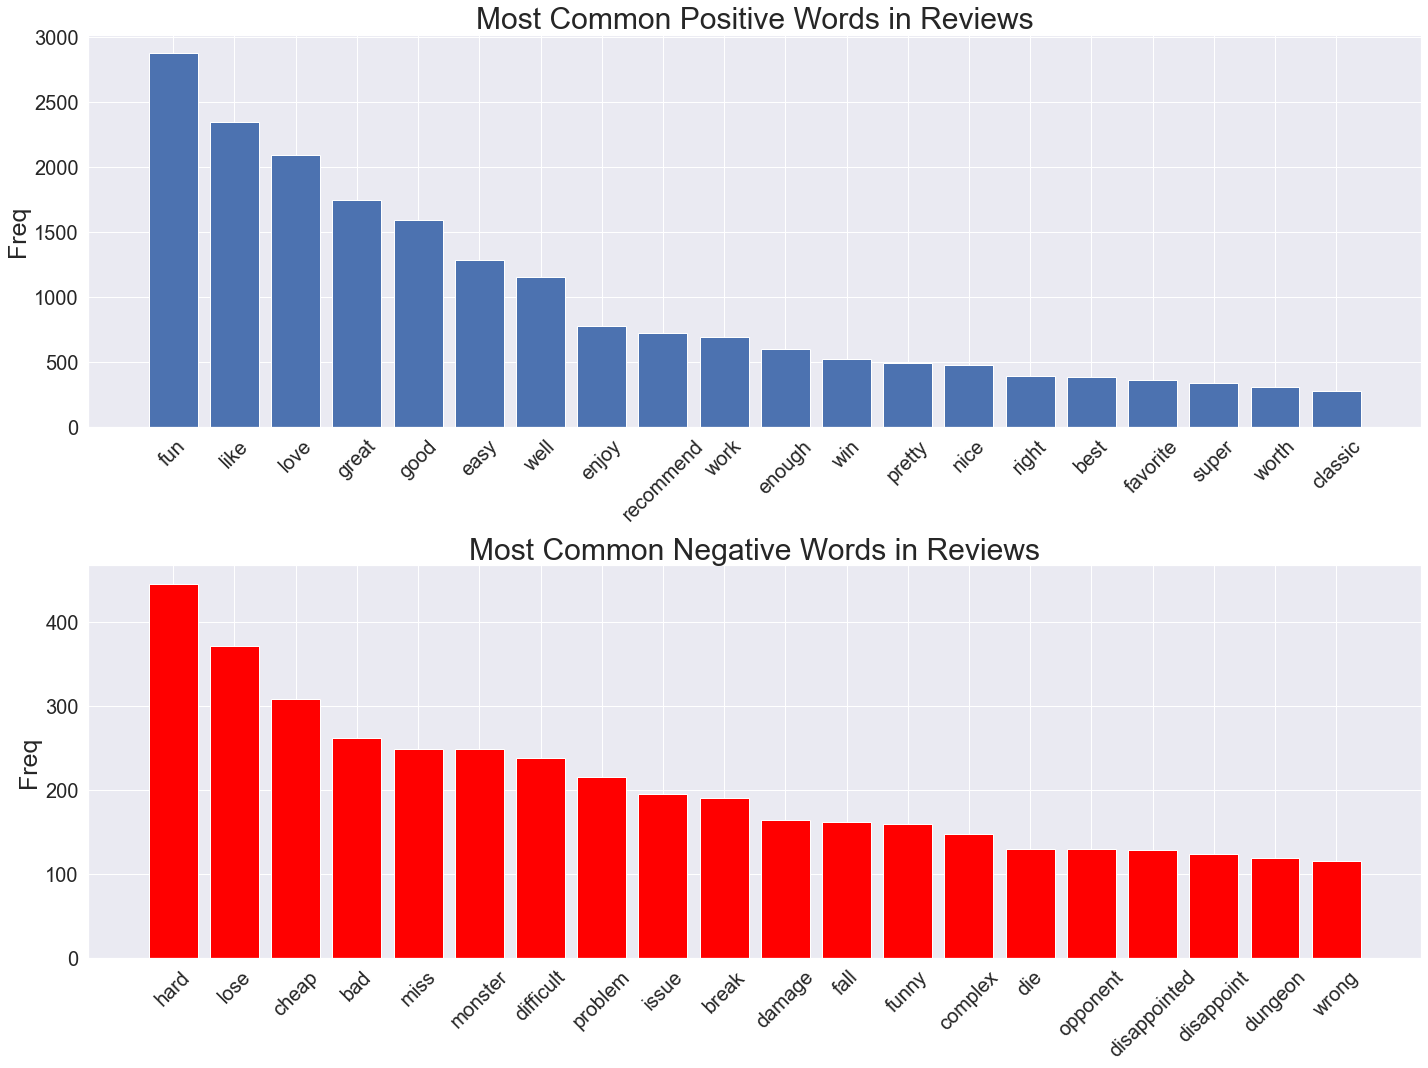

In [372]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,15 ## Sets the height and width of image

fig,ax=plt.subplots(2,1)

top_20_positive_words = dict(list(positive_words.items())[:20])
keys = top_20_positive_words.keys()
values = top_20_positive_words.values()
ax[0].bar(keys, values)
ax[0].set_title('Most Common Positive Words in Reviews',fontsize=30)
# ax[0].set_xlabel('Word',fontsize=25)
ax[0].set_ylabel('Freq',fontsize=25)
ax[0].tick_params(axis='x',labelsize=20,rotation=45)
ax[0].tick_params(axis='y',labelsize=20);

top_20_negative_words = dict(list(negative_words.items())[:20])
keys = top_20_negative_words.keys()
values = top_20_negative_words.values()
ax[1].bar(keys, values,color='red')
# ax[1].bar(keys, values)
ax[1].set_title('Most Common Negative Words in Reviews',fontsize=30)
# ax[1].set_xlabel('Word',fontsize=25)
ax[1].set_ylabel('Freq',fontsize=25)
ax[1].tick_params(axis='x',labelsize=20,rotation=45)
ax[1].tick_params(axis='y',labelsize=20)

fig.tight_layout()

plt.savefig('images/bar_plot_most_common_positive_negative_words_in_reviews.png');

## WordCloud - Most Common Words in Positive Reviews

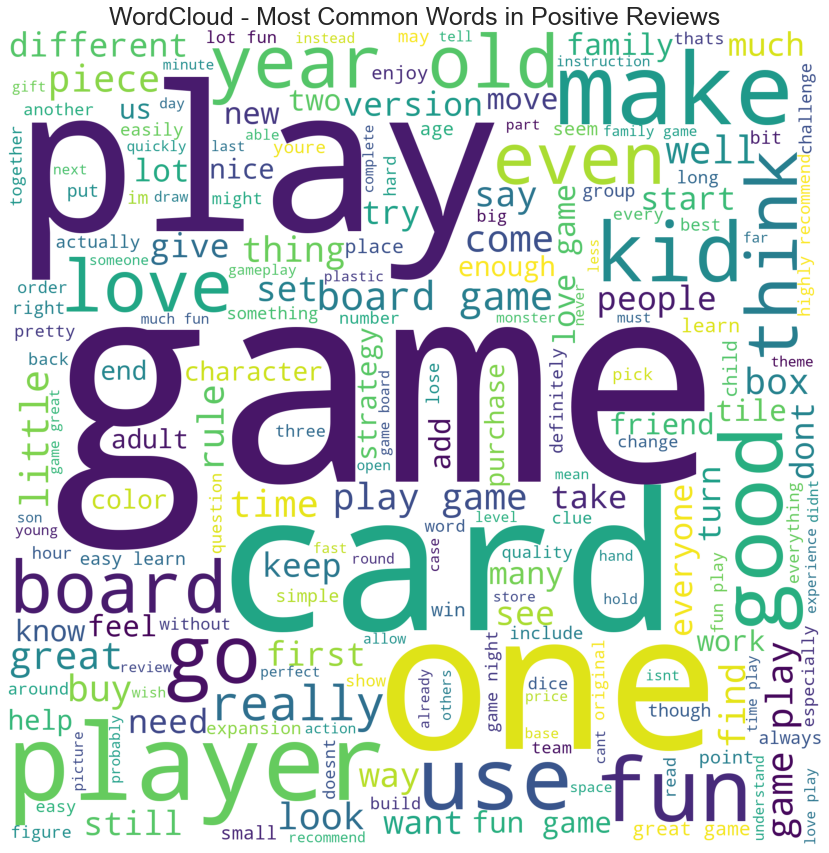

<Figure size 1440x1080 with 0 Axes>

In [377]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=2000, width=2000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(final_df[final_df['user_rating'] >= 4]['cleaned_reviews'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words in Positive Reviews", fontsize=25)
plt.axis('off')
plt.show()

plt.savefig('images/wordcloud_most_positive_common_words_in_reviews.png');

## WordCloud - Most Common Words in Negative Reviews

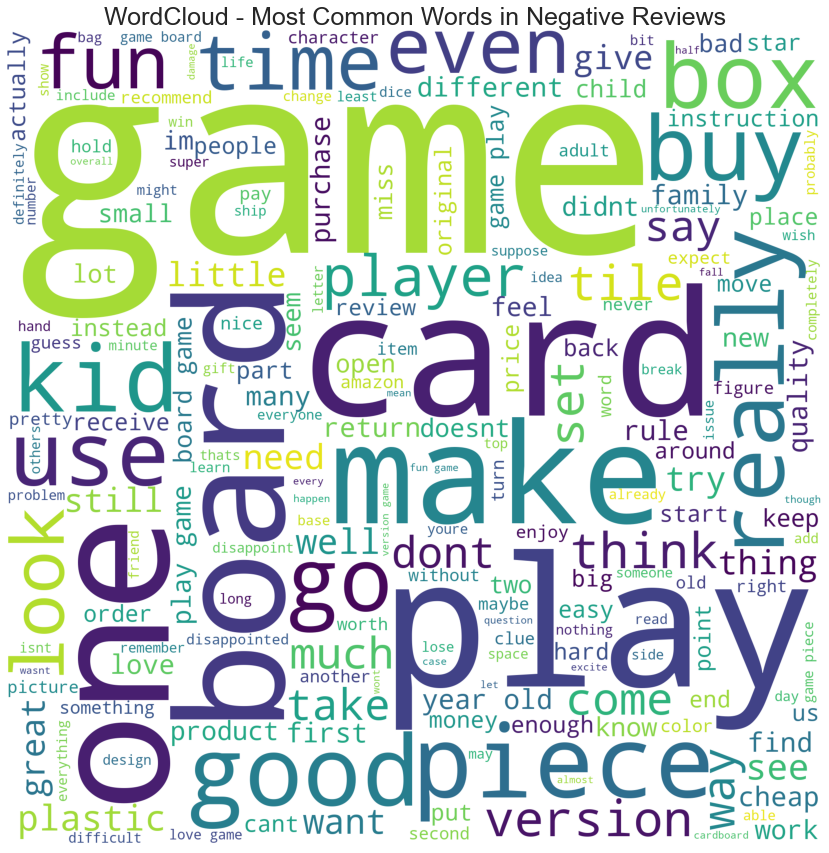

<Figure size 1440x1080 with 0 Axes>

In [378]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=2000, width=2000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(final_df[final_df['user_rating'] < 4]['cleaned_reviews'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words in Negative Reviews", fontsize=25)
plt.axis('off')
plt.show()

plt.savefig('images/wordcloud_most_negative_common_words_in_reviews.png');

# Count of Reviews for each Item

In [375]:
# number of user_ratings for each board game
table = pd.pivot_table(final_df, index=['asin_id'], columns=['user_rating'],
                       aggfunc='count',
                       fill_value=0.0)['cleaned_reviews']
table['total'] = table[1.0] + table[2.0] + table[3.0] + table[4.0] + table[5.0]
table

user_rating,1.0,2.0,3.0,4.0,5.0,total
asin_id,,,,,,
0786955708,1,2,3,6,18,30
0786958731,0,1,4,2,23,30
0975277324,4,3,2,5,16,30
1223063151,6,4,3,5,12,30
1589935012,0,0,1,0,0,1
...,...,...,...,...,...,...
B08DNN3MZC,0,0,0,0,3,3
B08F65MX4L,0,0,1,0,0,1
B08GD242TJ,0,0,0,1,2,3
